In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from tqdm import tqdm
import cmocean as cm
import sys, os
from datetime import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
from dask.distributed import Client
import xarray as xr
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Load workers:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43753,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34821,Total threads: 1
Dashboard: /proxy/35733/status,Memory: 35.97 GiB
Nanny: tcp://127.0.0.1:35343,


In [3]:
time_coord = slice('1982-01-01','2023-12-31')

### When I did this initially, had to split up my data into -80 to -70 then -70 to -63, this is hugely computationally expensive
yt_coord = slice(-80,-63)
xt_coord = slice(-60,40)

In [4]:
SSTa = xr.open_mfdataset(['/scratch/e14/ts7341/SSTa.nc',
                          '/scratch/e14/ts7341/SSTa_early_period.nc'])

In [5]:
SSTa

<xarray.Dataset> Size: 24GB
Dimensions:    (time: 15338, lat: 266, lon: 1440)
Coordinates:
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    dayofyear  (time) int64 123kB dask.array<chunksize=(6574,), meta=np.ndarray>
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
Data variables:
    sst        (time, lat, lon) float32 24GB dask.array<chunksize=(6574, 266, 1440), meta=np.ndarray>

In [6]:
import glob
import xarray as xr
import re

# Get a list of all NetCDF files
filelist = glob.glob('/g/data/e14/asg561/MHW_xarray/mhw_data_90pc/mhw*.nc')

# Define a regex pattern to match latitudes -90to-70 or -70to-50
pattern = re.compile(r'\.(-90to-70|-70to-50)\.')

# Filter the file list based on the pattern
filtered_files = [f for f in filelist if pattern.search(f)]

# Check if there are matching files
if filtered_files:
    # Open only the filtered files
    satellite_data = xr.open_mfdataset(filtered_files, combine='by_coords')
    print(satellite_data)
else:
    print("No matching files found!")

NOAA_SSTa = satellite_data.sel(time = slice('1982-01-01','2023-12-29')).\
                            sel(lat = slice(-82,-50))

<xarray.Dataset> Size: 59GB
Dimensions:         (time: 15688, lat: 160, lon: 1440, time366: 366)
Coordinates:
  * lat             (lat) float32 640B -89.88 -89.62 -89.38 ... -50.38 -50.12
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time            (time) datetime64[ns] 126kB 1981-12-30 ... 2024-12-11
  * time366         (time366) datetime64[ns] 3kB 1983-12-30 ... 1984-12-29
Data variables:
    severity        (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    severity_index  (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ssta            (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sst             (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology90   (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology     (time366, lat, lon) float32 337MB d

In [7]:
import numpy as np
import xarray as xr

# --- Convert longitudes from 0-360 to -180 to 180 ---
print("Converting longitudes from 0-360 to -180 to 180...")

SSTa['lon'] = ((SSTa['lon'] + 180) % 360) - 180

# Sort the coordinates to ensure monotonic increase for xESMF
SSTa = SSTa.sortby('lon')
print("Longitudes converted and sorted.")

# Optional sanity check
print(f"Longitude range: {SSTa.lon.min().values} to {SSTa.lon.max().values}")


Converting longitudes from 0-360 to -180 to 180...
Longitudes converted and sorted.
Longitude range: -179.875 to 179.875


In [8]:
model_aligned_time = SSTa.sst


model_da = model_aligned_time.sel(lat=slice(-70, -63)).chunk({'time': -1})
model_da = model_da.sel(time = slice('1982','2023-12-29'))

In [9]:
model_da

<xarray.DataArray 'sst' (time: 15338, lat: 66, lon: 1440)> Size: 6GB
dask.array<rechunk-merge, shape=(15338, 66, 1440), dtype=float32, chunksize=(15338, 66, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 528B -69.99 -69.88 -69.78 ... -63.28 -63.17 -63.06
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    dayofyear  (time) int64 123kB dask.array<chunksize=(15338,), meta=np.ndarray>
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...

In [10]:
NOAA_SSTa['time'] = NOAA_SSTa['time'] + np.timedelta64(12, 'h')

In [11]:
sat_aligned_time = satellite_data.ssta
satellite_da = sat_aligned_time.chunk({'time':-1})

In [12]:
import numpy as np

# Convert longitudes from 0–360 to -180–180
satellite_da = satellite_da.assign_coords(
    lon=((satellite_da.lon + 180) % 360) - 180
)

# Sort the longitudes so they are monotonically increasing
satellite_da = satellite_da.sortby('lon')

# Optional: sanity check
print(f"Longitude range after conversion: {satellite_da.lon.min().values} to {satellite_da.lon.max().values}")


Longitude range after conversion: -179.875 to 179.875


In [13]:
sat_da = satellite_da.sel(lat = slice(-70, -63)).sel(time = slice('1982','2023-12-29'))#.isel(lon=lon_mask)

sat_da['time'] = sat_da['time'] + np.timedelta64(12, 'h')
sat_da = sat_da.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 28.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [14]:
import numpy as np
import xarray as xr
from scipy.stats import t

## Regridding using the xe.Regridder tool from Cosima cookbook recipe
regridder = xe.Regridder(model_da, sat_da, 'bilinear')
model_regridded = regridder(model_da)

print("Regridding complete.")
print("Satellite Data Shape:  ", sat_da.shape)
print("Regridded Model Shape: ", model_regridded.shape)


--- Step 1: Aligning Grids ---
Regridding complete.
Satellite Data Shape:   (15338, 28, 1440)
Regridded Model Shape:  (15338, 28, 1440)


In [15]:
model_regridded = model_regridded.load()

In [16]:
# Compute lag-1 autocorrelation
def lag1_autocorr(x):
    return np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else 0

# Correlation with effective sample size (Neff) and adjusted p-value
def corr_with_autocorr(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    N = len(x)
    if N < 5:
        return np.nan, np.nan, np.nan

    r = np.corrcoef(x, y)[0, 1]

    # Effective sample size
    r1, r2 = lag1_autocorr(x), lag1_autocorr(y)
    Neff = N * (1 - r1*r2) / (1 + r1*r2)
    Neff = max(3, Neff)  # avoid too small df

    # Adjusted t-test
    tval = r * np.sqrt((Neff - 2) / (1 - r**2))
    pval = 2 * (1 - t.cdf(abs(tval), df=Neff-2))
    return r, Neff, pval

# Apply across grid cells
def gridcell_correlation(sat, model):
    return xr.apply_ufunc(
        corr_with_autocorr,
        sat, model,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, float]
    )


In [17]:
# Loop over months 1-12
all_months = []

for month in range(1, 13):
    print(f"\n--- Processing month {month} ---")
    
    # Select all daily values of this month across all years
    sat_m = sat_da.sel(time=sat_da['time.month'] == month)
    model_m = model_regridded.sel(time=model_regridded['time.month'] == month)

    # Compute correlation, effective sample size, and p-value
    r, Neff, pval = gridcell_correlation(sat_m, model_m)

    # Create a dataset for this month
    ds_month = xr.Dataset({
        "r": r,        
        "Neff": Neff,
        "pval": pval
    }, coords={"lat": sat_da.lat, "lon": sat_da.lon})
    
    # Add a month dimension
    ds_month = ds_month.expand_dims(month=[month])
    
    # Append to list
    all_months.append(ds_month)

# Concatenate all months along the 'month' dimension
ds_all = xr.concat(all_months, dim='month')

# Optional: save full dataset to NetCDF
ds_all.to_netcdf("/scratch/e14/ts7341/full_corr/full_corr_lower_lats.nc")
print("Saved combined correlation dataset with month dimension.")



--- Processing month 1 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 2 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 3 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 4 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 5 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 6 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 7 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 8 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 9 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 10 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 11 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 12 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Saved combined correlation dataset with month dimension.


## Plot the Correlation

In [3]:
ds = xr.open_mfdataset(['/scratch/e14/ts7341/full_corr/full_corr_lower_lats.nc',
                        '/scratch/e14/ts7341/full_corr/full_corr_high_lats.nc'])
ds

<xarray.Dataset> Size: 23MB
Dimensions:  (month: 12, lat: 56, lon: 1440)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 224B -76.88 -76.62 -76.38 ... -63.62 -63.38 -63.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    r        (month, lat, lon) float64 8MB dask.array<chunksize=(12, 28, 1440), meta=np.ndarray>
    Neff     (month, lat, lon) float64 8MB dask.array<chunksize=(12, 28, 1440), meta=np.ndarray>
    pval     (month, lat, lon) float64 8MB dask.array<chunksize=(12, 28, 1440), meta=np.ndarray>

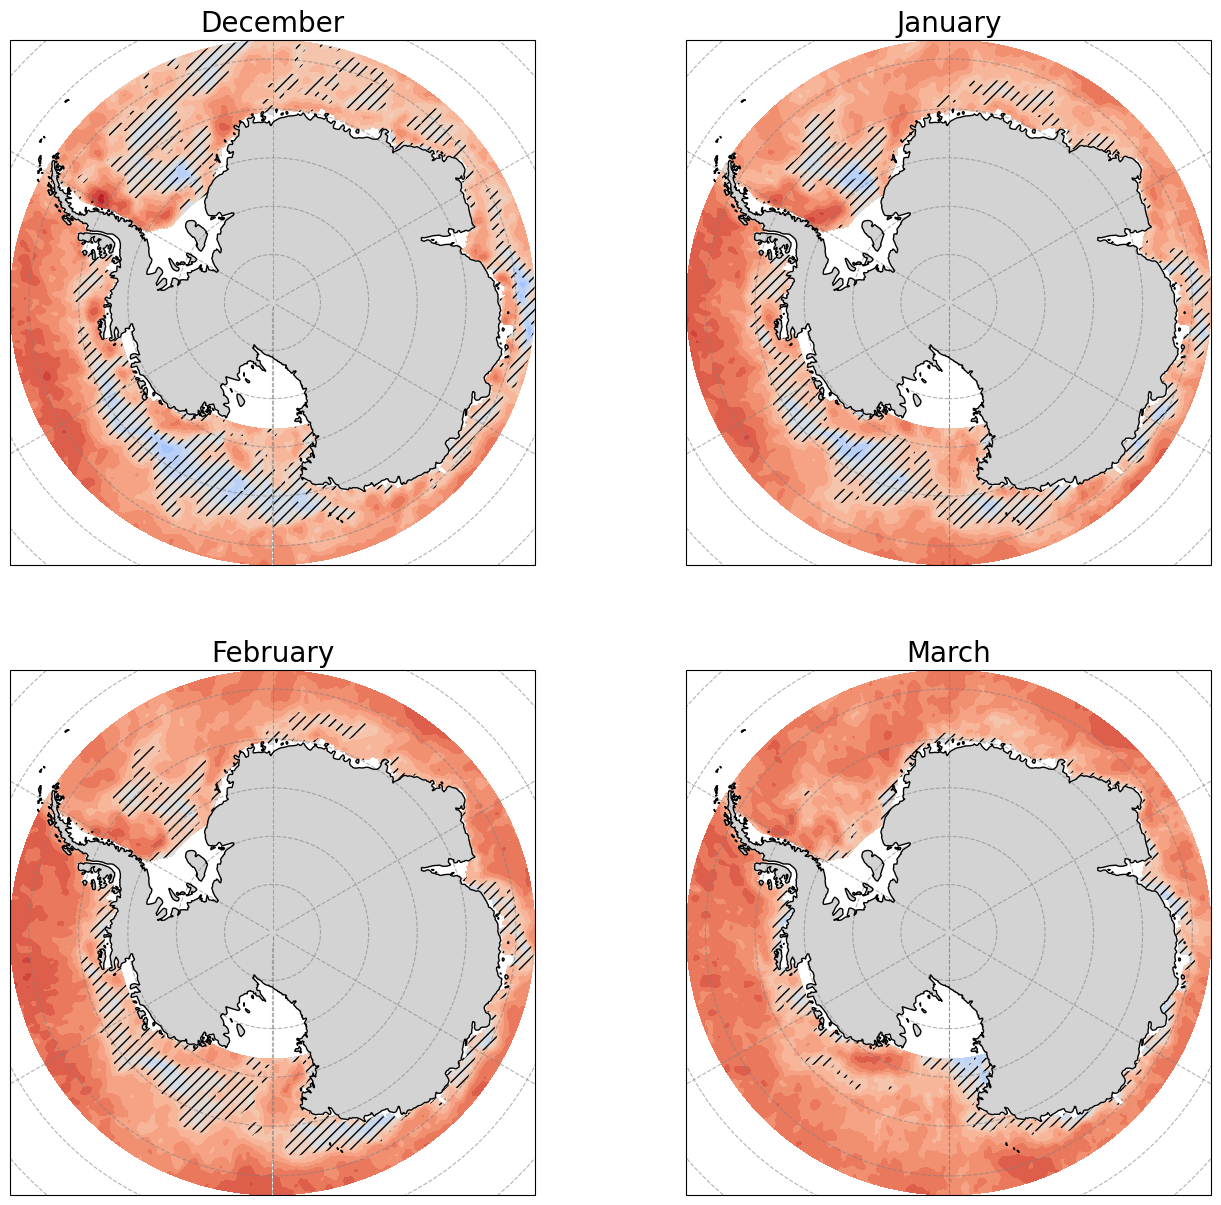

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature # Import for land/ocean features
import numpy as np
import calendar

# Define the specific months to plot
months_to_plot = [12, 1, 2, 3]

# Define your significance level (alpha)
alpha = 0.05

# Create a 2x2 grid for the four plots
fig, axes = plt.subplots(2, 2,
                         figsize=(16, 15), # Keeping the larger size
                         subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Loop through the axes and the list of months to plot
for i, ax in enumerate(axes.flat):
    if i >= len(months_to_plot):
        ax.set_visible(False)
        continue

    month_val = months_to_plot[i]

    # Select data directly from the ds using the month dimension
    r = ds.r.sel(month=month_val)
    p_values = ds.pval.sel(month=month_val)
    lat = ds.lat
    lon = ds.lon

    # Main color contour plot for correlation values
    cf = ax.contourf(lon, lat, r,
                     levels=np.linspace(-1, 1, 21),
                     transform=ccrs.PlateCarree(),
                     cmap='coolwarm', extend='both',
                     zorder=0)

    # Hatching for non-significant areas
    ax.contourf(lon, lat, p_values,
                levels=[alpha, 1],
                colors='none',
                hatches=["///"],
                transform=ccrs.PlateCarree(),
                zorder=2)

    # Color the landmass gray
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)

    # Add coastlines
    ax.coastlines(resolution='50m', zorder=3)

    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.6)

    # Set the title for each subplot
    month_name = calendar.month_name[month_val]
    ax.set_title(month_name, fontsize=20)

# plt.tight_layout()

# fig.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/correlation.png',    
#             dpi=800,              
#             bbox_inches='tight')   

# plt.show()

## Add Ice Edge

In [3]:
## LOAD IN SEA-ICE DATA FROM ACCESS-OM2
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

## HAVE TO ASSIGN THE DAYS FROM THE SEA-ICE DATA TO THE CLIMATOLOGY
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

clim = ice_clim.sel(dayofyear=ice['dayofyear'])

clim_ice_access = clim.aice.load()
ice_access = ice.aice.load()

In [5]:
##LOAD IN THE NOAA SEA-ICE DATA HERE 
import glob
import xarray as xr
import re

import xarray as xr

# Open only 2000–2023 files
sea_ice = xr.open_mfdataset(
    [
        f'/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/icec.day.mean.{year}.nc'
        for year in range(1982, 2024)
    ],
    combine='by_coords',
    chunks={'time': 365}  # chunk by year to reduce memory usage
)

# Select Antarctic region (latitudes south of -55)
sea_ice = sea_ice.sel(lat=slice(-90, -55))

ice_clim = xr.open_dataset('/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/ice_clim.nc')
ice_clim

# Assign dayofyear to c_ice
c_ice = sea_ice.assign_coords(dayofyear=sea_ice['time'].dt.dayofyear)

# Align climatology using dayofyear and assign dates from temp
climatology_ice = ice_clim.sel(dayofyear=c_ice['dayofyear'])
climatology_ice = climatology_ice.icec.assign_coords(time=c_ice['time'])

noaa_sea_ice = c_ice.icec
noaa_clim_sea_ice = climatology_ice

In [6]:
print(ice_access)
print(noaa_sea_ice)

<xarray.DataArray 'aice' (time: 15338, yt_ocean: 233, xt_ocean: 1440)> Size: 21GB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [4.47810235e-05, 6.26182155e-05, 4.67958489e-05, ...,
         1.05928368e-04, 8.85073023e-05, 6.15886165e-05],
        [8.74805264e-05, 6.97851865e-05, 5.19684800e-05, ...,
         1.34543850e-04, 1.29004271e-04, 1.03831517e-04],
        [1.09873930e-04, 1.14813505e-04, 9.62132981e-05, ...,
         1.33686044e-04, 1.31046196e-04, 1.15682895e-04]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
 

In [7]:
aice = aice.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})

NameError: name 'aice' is not defined

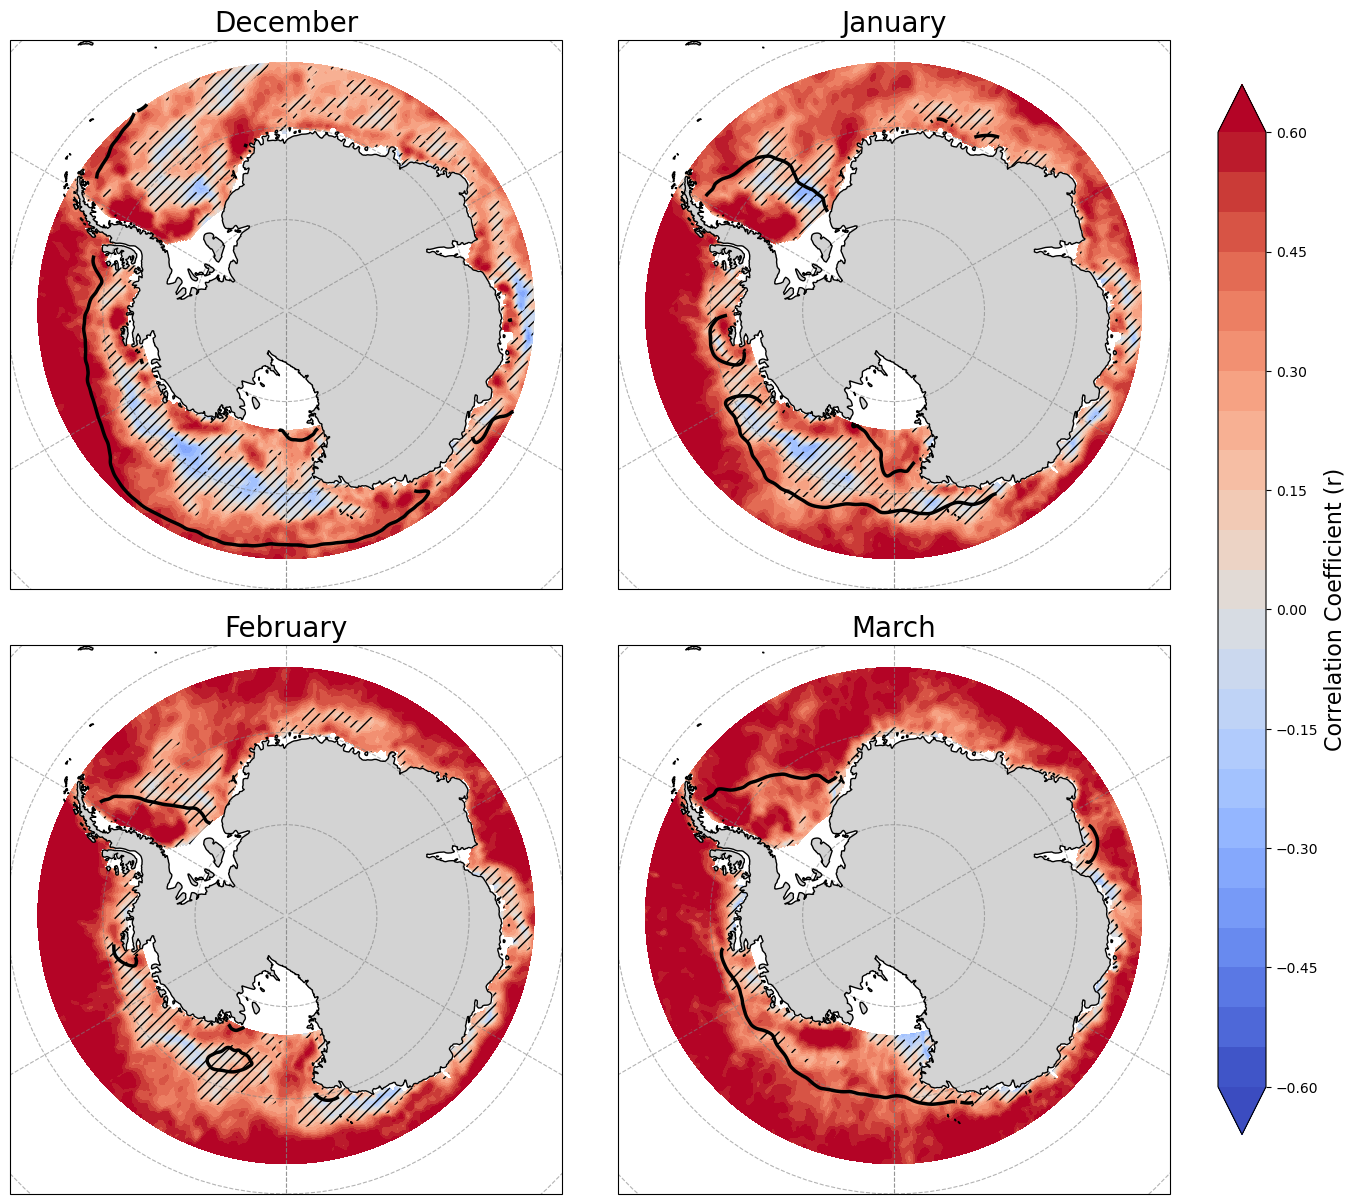

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import calendar
import xarray as xr
from scipy.ndimage import gaussian_filter

aice_clim = clim_ice_access.sel(time = slice('1982-01-01','1982-12-31')).groupby('time.month').mean(dim='time')

aice_clim_subset = aice_clim.sel(yt_ocean=slice(-77, -63))

months_to_plot = [12, 1, 2, 3]
alpha = 0.05

fig, axes = plt.subplots(2, 2,
                         figsize=(16, 15),
                         subplot_kw={'projection': ccrs.SouthPolarStereo()})

# --- Step 3: Loop Through Months and Create Each Plot ---

for i, ax in enumerate(axes.flat):
    if i >= len(months_to_plot):
        ax.set_visible(False)
        continue

    month_val = months_to_plot[i]
    month_name = calendar.month_name[month_val]
    ax.set_title(month_name, fontsize=20)

    # Set map extent
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    # --- Part A: Plot the background correlation and significance ---
    # This part remains unchanged.
    r_for_month = ds.r.sel(month=month_val)
    p_values = ds.pval.sel(month=month_val)

    cf = ax.contourf(ds.lon, ds.lat, r_for_month,
                     levels=np.linspace(-0.6, 0.6, 25),
                     transform=ccrs.PlateCarree(),
                     cmap='coolwarm', extend='both', zorder=0)

    ax.contourf(ds.lon, ds.lat, p_values,
                levels=[alpha, 1],
                colors='none', hatches=["///"],
                transform=ccrs.PlateCarree(), zorder=2)

    # --- Part B: Smooth and plot the sea ice contour ---
    # This is now much simpler. NO REGRIDDING NEEDED.

    # 1. Select the month from our subsetted climatology
    ice_for_month = aice_clim_subset.sel(month=month_val)

    # 2. Smooth the data values
    ice_smoothed = gaussian_filter(ice_for_month.values, sigma=2)

    # 3. Plot the final contour using its own coordinates: xt_ocean and yt_ocean
    ax.contour(ice_for_month.xt_ocean, ice_for_month.yt_ocean, ice_smoothed,
               levels=[0.35],
               colors='black',
               linewidths=2.5,
               transform=ccrs.PlateCarree(),
               zorder=4)

    # --- Part C: Add Map Features ---
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax.coastlines(resolution='50m', zorder=3)
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.6)

# --- Step 4: Finalize the Figure ---
fig.subplots_adjust(right=0.85, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax)
cbar.set_label('Correlation Coefficient (r)', fontsize=16)

plt.show()

--- Aligning Time Coordinates ---
Original NOAA time steps: 15340
Original ACCESS time steps: 15338
Found 15338 common dates for alignment.

Regridding NOAA data onto the ACCESS grid...
Regridding complete.


Calculating annual minimum extent...


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 23.03 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Calculation complete.


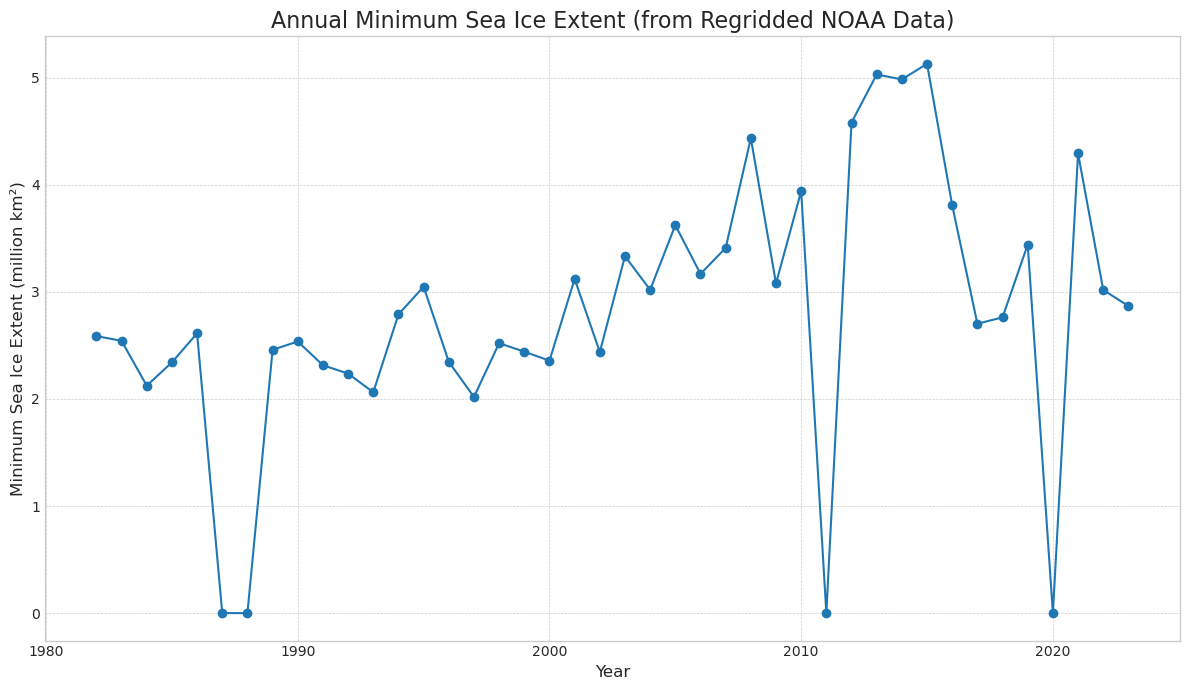

In [8]:
import xarray as xr
import numpy as np
import pandas as pd # Using pandas for robust time handling
import matplotlib.pyplot as plt
import xesmf as xe

# Your data is already loaded:
# ice_access
# noaa_sea_ice

# --- Step 1: Prepare the Grids for Regridding (No change here) ---
target_grid = xr.Dataset({
    'lat': ice_access['TLAT'],
    'lon': ice_access['TLON'],
})
source_data = noaa_sea_ice

# --- Step 2: Handle Different Time Coordinates (CORRECTED LOGIC) ---
print("--- Aligning Time Coordinates ---")
# Normalize both time coordinates to midnight to compare dates only
source_dates = pd.to_datetime(source_data['time'].values).normalize()
access_dates = pd.to_datetime(ice_access['time'].values).normalize()

# Find the common dates and the indices for each array that correspond to them
common_dates, source_indices, access_indices = np.intersect1d(
    source_dates, access_dates, return_indices=True
)

# Check if there is any overlap at all
if len(common_dates) == 0:
    raise ValueError(
        "Time coordinates have no overlapping dates even after normalization. "
        f"NOAA range: {source_dates.min()} to {source_dates.max()}. "
        f"ACCESS range: {access_dates.min()} to {access_dates.max()}."
    )

# Use the indices to select the corresponding data. This is efficient.
source_data_aligned = source_data.isel(time=source_indices)
ice_access_aligned = ice_access.isel(time=access_indices)

print(f"Original NOAA time steps: {len(noaa_sea_ice.time)}")
print(f"Original ACCESS time steps: {len(ice_access.time)}")
print(f"Found {len(common_dates)} common dates for alignment.")


# --- Step 3: Create and Apply the Regridder (No change here) ---
regridder = xe.Regridder(source_data_aligned, target_grid, 'bilinear', periodic=True)
print("\nRegridding NOAA data onto the ACCESS grid...")
noaa_regridded = regridder(source_data_aligned, keep_attrs=True)
print("Regridding complete.")


# --- Step 4: Calculate Sea Ice Extent (No change here) ---
# This part assumes you have the 'tarea' variable.
try:
    tarea_name = ice_access.attrs['cell_measures'].split(': ')[-1]
    cell_areas = ice_access_aligned.coords[tarea_name]
    print(f"\nFound and using cell area variable: '{tarea_name}'")
except (KeyError, AttributeError):
    print("\nWARNING: Could not automatically find 'tarea'. Creating a placeholder.")
    R = 6371e3
    dlon_rad = np.deg2rad(np.median(np.diff(ice_access.xt_ocean)))
    dlat_rad = np.deg2rad(np.median(np.diff(ice_access.yt_ocean)))
    cell_areas = (R**2) * np.cos(np.deg2rad(ice_access_aligned.TLAT)) * dlon_rad * dlat_rad

is_ice_present = noaa_regridded >= 0.15
# We need to make sure the time coordinate from the regridded data is used.
daily_extent = (is_ice_present * cell_areas).sum(dim=['yt_ocean', 'xt_ocean'])
daily_extent['time'] = common_dates # Assign the clean, common time coordinate

# --- Step 5: Find the Annual Minimum Extent (This will now work) ---
print("\nCalculating annual minimum extent...")
annual_min_extent = daily_extent.groupby('time.year').min().compute()
print("Calculation complete.")


# --- Step 6: Plot the Result (No change here) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot extent in millions of square kilometers (assuming 'tarea' is in m^2).
(annual_min_extent / 1e12).plot(ax=ax, marker='o', linestyle='-')

ax.set_title('Annual Minimum Sea Ice Extent (from Regridded NOAA Data)', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Minimum Sea Ice Extent (million km²)', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [47]:
print(noaa_clim_sea_ice)
print(clim)

<xarray.DataArray 'icec' (lat: 140, lon: 1440, time: 15340)> Size: 12GB
[3092544000 values with dtype=float32]
Coordinates:
  * lat        (lat) float32 560B -89.88 -89.62 -89.38 ... -55.62 -55.38 -55.12
  * lon        (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
  * time       (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
Attributes:
    long_name:     Daily Sea Ice Concentration
    units:         percent
    valid_range:   [0. 1.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Ice Concentration
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [0.01 1.  ]
<xarray.DataArray 'aice' (yt_ocean: 233, xt_ocean: 1440, time: 15338)> Size: 21GB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,

In [30]:
noaa_anom = noaa_sea_ice - noaa_clim_sea_ice
access_anom = ice_access - clim

In [11]:
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

In [13]:
area = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='area_t', 
    session=session,
    frequency='static',
    attrs={'cell_methods': 'time: point'},
    n=1
)
area = area.sel(yt_ocean = slice(-90,-50)).load()

In [16]:
access_area = area

In [11]:
clim_ice_access

<xarray.DataArray 'aice' (yt_ocean: 233, xt_ocean: 1440, time: 15338)> Size: 21GB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.00045483, 0.00047061, 0.0004844 , ..., 0.00026495,
         0.00022874, 0.00020254],
        [0.0003943 , 0.00041385, 0.00043073, ..., 0.0002582 ,
         0.00022039, 0.00019167],
        [0.00036951, 0.00038999, 0.00040696, ..., 0.00029834,
         0.00026287, 0.00023405]],

       [[0.00032082, 0.00033851, 0.00035262, ..., 0.00035146,
         0.00031341, 0.00028188],
        [0.00032731, 0.00034446, 0.000359  , ..., 0.00042482,
         0.00038541, 0.00035223],
        [0.0003118 , 0.00032618, 0.00033973, ..., 0.00047849,
         0.00043745, 0.00040276],
        ...,
        [0.00040291, 0.0004157 , 0.00042689, ..., 0.00025867,
         0.00021999, 0.00019107],
        [0.00034362, 0.00035942, 0.00037306, ..., 0.00026115,
         0.00022056, 0.00018939],
        [0.00031454, 0.00033171, 0.00034562, ..., 0.00028606,
         0.00024659, 0.00021533]]], dtype=float32)
Coordinates:
    TLON       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... 79.62 79.88
    TLAT       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... -55.14 -55.14
    ULON       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... 79.25 79.5 79.75
    ULAT       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... -55.07 -55.07
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
Attributes:
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    units:          1
    time_rep:       averaged